<a href="https://colab.research.google.com/github/astorguy/learn_ngspice/blob/main/notebooks/rlc/rlc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs and imports.

This notebook can be run in Google Colab or in Jupyter. However, the setup is slightly different. This function tests which environment we are in.

In [25]:
def is_running_in_colab() -> bool:
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

In [26]:
import subprocess, sys

if not is_running_in_colab():
    subprocess.run(["sudo", "apt-get", "update"], check=True)
    subprocess.run(["sudo", "apt-get", "install", "-y", "ngspice"], check=True)
else:
    subprocess.run(["apt-get", "install", "-y", "ngspice"], check=True)

subprocess.check_call([sys.executable, "-m", "pip", "install", "py4spice"])

Hit:1 http://deb.debian.org/debian trixie InRelease
Hit:2 http://deb.debian.org/debian trixie-updates InRelease
Hit:3 http://deb.debian.org/debian-security trixie-security InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
ngspice is already the newest version (44.2+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


0

In [27]:
from pathlib import Path
from types import SimpleNamespace
import py4spice

# Ngspice simulation of RLC

### Define paths
There are paths and files to define. We're put them into a namespace to keep things organized. Two subdirectories are also defined:
- netlists
- results

In [28]:
paths = SimpleNamespace() # create the namespace for the class

paths.ngspice = Path("/usr/bin/ngspice")
paths.workspace = Path.cwd()
paths.netlists = paths.workspace /Path("netlist")
paths.results = paths.workspace / Path("results")
paths.top = paths.netlists / Path("top.cir")
paths.sim_transcript = paths.results / Path("sim_transcript.log")

# create these directories if the don't yet exist
paths.netlists.mkdir(parents=True, exist_ok=True)
paths.results.mkdir(parents=True, exist_ok=True)

# create an empty file for sim_transcript
paths.sim_transcript.write_text("")

0

### Netlists namespace
Netlist objects are created. These netlist snippets will be used later to create a single top-level netlist which will be read in during the batch simulation. Again, we put them into a namespace to keep things organized.

In [29]:
netlists = SimpleNamespace() # create the namespace for the class

netlists.blankline = py4spice.Netlist("")
netlists.title = py4spice.Netlist("* my ngspice netlist")
netlists.end = py4spice.Netlist(".end")

### Creating DUT (Device Under Test)
Though this circuit is simple, we are going to separate the DUT from all the other parts of the netlist. The simulations, title, and `.end` lines will be added separately.

We want to measure the current through the capacitor and the inductor. Therefore, we do the old spice trick of adding 0 volt source in series. (Ugly, but effective)

In [30]:
dut_contents = """
r1 out 0 100
l1 out lmid 10e-6 ic=300e-3
vil lmid 0 dc 0
c1 out cmid 10e-9
vic cmid 0 dc 0
""".strip()

netlists.dut = py4spice.Netlist(dut_contents)

### Vectors dictionary
Vectors objects are used to define a set of circuit signals to create and display. Again, we put them into a dictionary to keep things organized.

In [31]:
vectors = SimpleNamespace() # create the namespace for the class

vectors.all = py4spice.Vectors("all")
vectors.out = py4spice.Vectors("out")
vectors.vil_branch = py4spice.Vectors("vil#branch")
vectors.vic_branch = py4spice.Vectors("vic#branch")
vectors.currents = vectors.vil_branch + vectors.vic_branch

vectors.I_inductor = py4spice.Vectors("I_inductor") # rename for nice plots
vectors.I_capacitor = py4spice.Vectors("I_capacitor") # rename for nice plots
vectors.currents_renamed = vectors.I_inductor + vectors.I_capacitor

### Analyses to run during the simulation process
Each batch simulation in Ngspice can perform one or more analyses. We will create a list of analyses to make it easier to reuse the code. The Analysis object has the following arguments:

| Argument | Description |
| :--- | :--- |
| **name** | Label given to the object. |
| **cmd_type** | Ngspice has different types of analyses. The `op`, `tran`, `ac`, and `dc` analyses are supported with `py4spice`. |
| **cmd** | This is the actual command that will be sent to Ngspice. Its arguments can be found in the Ngspice documentation. |
| **vector** | This defines which signals will be in the simulation results. |
| **results_loc** | Where to put the results files. |

In [32]:
list_of_analyses = []  # start with an empty list

# 1st analysis: operating point
tran1 = py4spice.Analyses(
    name="tran1",
    cmd_type="tran",
    cmd="tran 1e-9 5e-6 uic",
    vector=vectors.all,
    results_loc=paths.results,
)
list_of_analyses.append(tran1)


### Control section
This is the section that tells Ngspice what operations to do. A netlist object snippet is created. It will be concatenated with the other netlist objects to create the top-level netlist.

In [33]:
my_control = py4spice.Control()  # create 'my_control' object

# add all the analyses defined above into the control section
for analysis in list_of_analyses:
    my_control.insert_lines(analysis.lines_for_cntl())

# convert control section into a netlist object
netlists.control = py4spice.Netlist(str(my_control))

### Create a single netlist, ready for simulation
The netlist snippets are concatenated and merged into `top`. `top.cir` is written out. It will be read in during the simulation. We print out `top` to verify everything is correct.

In [34]:
# concatenate all tne netlists to make top1 and add to netlist dict
netlists.top = (
    netlists.title
    + netlists.blankline
    + netlists.dut
    + netlists.blankline
    + netlists.control
    + netlists.blankline
    + netlists.end
    + netlists.blankline
)

# write netlist to a file so ngspice can read it
netlists.top.write_to_file(paths.top)

# here is the netlist in top.cir and will be used for simulation
print(netlists.top)

* my ngspice netlist

r1 out 0 100
l1 out lmid 10e-6 ic=300e-3
vil lmid 0 dc 0
c1 out cmid 10e-9
vic cmid 0 dc 0

.control
* timestamp: sat feb  7 18:47:27 2026
set wr_singlescale  $ makes one x-axis for wrdata
set wr_vecnames     $ puts names at top of columns
tran 1e-9 5e-6 uic
wrdata /workspaces/learn_ngspice/notebooks/rlc/results/tran1.txt all
quit
.endc

.end



### Simulate
The Ngspice command is constructed, printed out for verification, and executed. `timeout` (in seconds) is set in case the simulation hangs.

In [35]:
# prepare simulate object and simulate
sim = py4spice.Simulate(
    ngspice_exe=paths.ngspice,
    netlist_filename=paths.top,
    transcript_filename=paths.sim_transcript,
    name="sim1",
    timeout=5,
)
# print out the command that will be used in the spawned process
print(sim.ngspice_command)

sim.run()  # run the Ngspice simulation

['/usr/bin/ngspice', '-b', '/workspaces/learn_ngspice/notebooks/rlc/netlist/top.cir']


### Create simResults objects
The raw results we get from Ngspice are large text files. We convert these to py4spice simResults objects so we can easily manipulate and display.

In [36]:
sim_results: list[py4spice.SimResults] = [
    py4spice.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
    for analysis in list_of_analyses
]

### Create Waveforms
Create waveforms from simulation data

In [37]:
# prepare waveform for current through inductor
out_waves = py4spice.Waveforms(sim_results[0].header, sim_results[0].data_plot)
out_waves.vec_subset(vectors.currents.list_out())
out_waves.scaler(1.0, "vil#branch", vectors.I_inductor.list_out()[0])  # rename
out_waves.scaler(1.0, "vic#branch", vectors.I_capacitor.list_out()[0])  # rename

### Plot
Right-click on plot and "Open image in new tab"

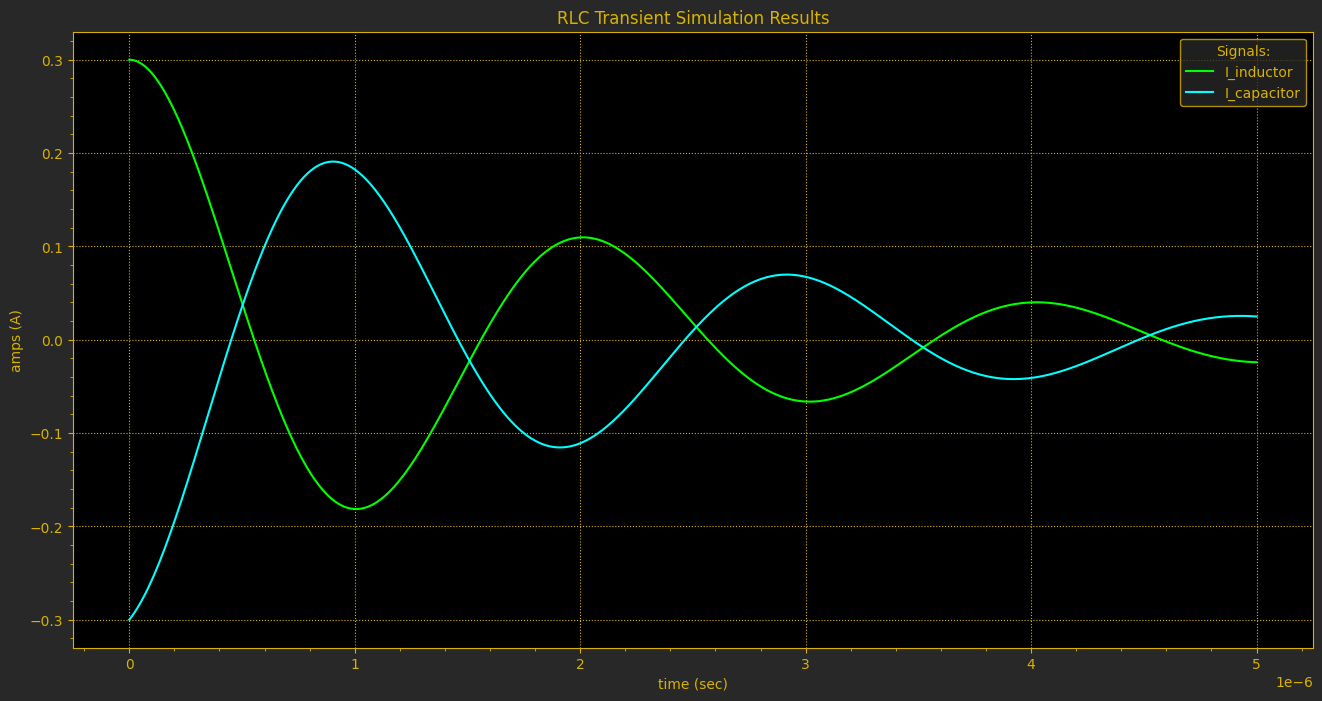

In [38]:
plot_data = out_waves.x_axis_and_sigs(vectors.currents_renamed.list_out())
y_names = vectors.currents_renamed.list_out()
my_plt = py4spice.Plot("tr_plt", plot_data, y_names, paths.results)
my_plt.set_title("RLC Transient Simulation Results")
my_plt.define_axes(("time", "sec", "linear"), ("amps", "A", "linear"))